# Poisson problem with Uniform refinement.


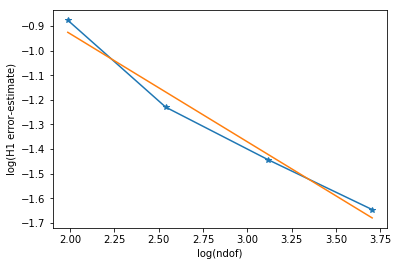

In [21]:
#Poisson problem with homogeneous Dirichlet boundary conditions using residual estimator and Dorfler marking


from ngsolve import *
import netgen.gui
from netgen.geom2d import SplineGeometry
from math import *
import numpy as np
%matplotlib inline

def MakeGeometry():
    geometry = SplineGeometry()
    
    # point coordinates ...
    pnts = [ (0,0), (1,0), (1,0.6), (0,0.6), \
             (0.2,0.6), (0.8,0.6), (0.8,0.8), (0.2,0.8), \
             (0.5,0.15), (0.65,0.3), (0.5,0.45), (0.35,0.3) ]
    pnums = [geometry.AppendPoint(*p) for p in pnts]
    
    # start-point, end-point, boundary-condition, domain on left side, domain on right side:
    lines = [ (0,1,1,1,0), (1,2,1,1,0), (2,5,1,1,0), (4,3,1,1,0), (3,0,1,1,0), \
              (5,6,1,1,0), (6,7,1,1,0), (7,4,1,1,0)]
        
    for p1,p2,bc,left,right in lines:
        geometry.Append( ["line", pnums[p1], pnums[p2]], bc=bc, leftdomain=left, rightdomain=right)
    return geometry



mesh = Mesh(MakeGeometry().GenerateMesh (maxh=1))
n = specialcf.normal(2)
h = specialcf.mesh_size


fes = H1(mesh, order=3, dirichlet=[1], autoupdate=True)
u = fes.TrialFunction()
v = fes.TestFunction()



a = BilinearForm(fes, symmetric=True)
a += grad(u)*grad(v)*dx

c = MultiGridPreconditioner(a, inverse = "sparsecholesky")
gfu = GridFunction(fes, autoupdate=True)
Draw (gfu)



f = LinearForm(fes)
fcoeff= CoefficientFunction(1)
f+=fcoeff*v*dx




def SolveBVP():
    a.Assemble()
    f.Assemble()
    inv = CGSolver(a.mat, c.mat)
    gfu.vec.data = inv * f.vec
    Redraw (blocking=True)


l = []

def hess(w): 
    return w.Operator("hesse")
def Lap(w):
   return hess(w)[0,0]+hess(w)[1,1]

def DorflerMarking(elerr):
        DorflerParam=0.25
        NpElError = np.array(elerr)
        SortedElError = np.sort(NpElError)[::-1]
        inds = np.argsort(NpElError)[::-1]
        Total = np.sum(NpElError)
        S=0
        counter=0
        while S<DorflerParam*Total:
            S=S+SortedElError[counter]
            counter=counter+1   
        for el in mesh.Elements():
            mesh.SetRefinementFlag(el, True) 
            for i in range(0,counter):
                el = mesh[ElementId(VOL,inds[i])]
                type(el)
                mesh.SetRefinementFlag(el,True)
 


def CalcError():
    err=(h*h)*((fcoeff+Lap(gfu))**2)*dx
    elerr = Integrate (err, mesh, element_wise=True)
    elerr += Integrate(h*0.5*((grad(gfu)-grad(gfu).Other())*n)**2*dx(element_boundary=True),mesh,element_wise=True)
    l.append ( (fes.ndof, sqrt(sum(elerr)) ))
    return elerr

    
    


with TaskManager():
    while fes.ndof < 10000:  
        SolveBVP()
        elerr=CalcError()
        DorflerMarking(elerr)
        mesh.Refine()
    
SolveBVP()

#print(count, 'count')

import matplotlib.pyplot as plt

plt.xlabel("log(ndof)")
plt.ylabel("log(H1 error-estimate)")
ndof,err = zip(*l)
plt.ion()
x=np.log10(np.array(ndof))
y=np.log10(np.array(err))
plt.plot(x,y, "-*")
m,b = np.polyfit(x, y, 1)
y1 = m*x+b

plt.plot(x,y1)

#plt.savefig('dorfler with uniform.png')
plt.show()



In [23]:
y

array([-0.87635086, -1.2295871 , -1.44263758, -1.64589978])

# Multiple plots (n=1,2,3) for uniform refinement

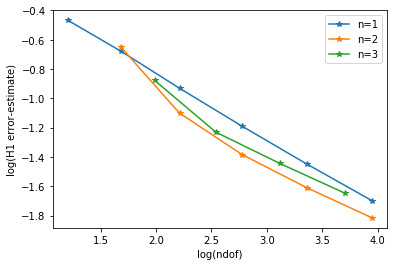

In [27]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

plt.xlabel("log(ndof)")
plt.ylabel("log(H1 error-estimate)")
x1=np.array([1.20411998, 1.68124124, 2.2121876 , 2.77597433, 3.35812529,
       3.95002391])
y1=np.array([-0.46660039, -0.67679001, -0.93063814, -1.18897597, -1.44650256,
       -1.69804386])
plt.plot(x1,y1, "-*")
x2=np.array([1.68124124, 2.2121876 , 2.77597433, 3.35812529, 3.95002391])
y2=np.array([-0.64828318, -1.10025595, -1.38252878, -1.60794604, -1.81494671])
plt.plot(x2,y2, "-*")
x3=np.array([1.98677173, 2.5390761 , 3.11494442, 3.7035493 ])
y3=np.array([-0.87635086, -1.2295871 , -1.44263758, -1.64589978])
plt.plot(x3,y3, "-*")
plt.legend(["n=1", "n=2","n=3"])
m1,b1 = np.polyfit(x1, y1, 1)
yp1 = m1*x1+b1
#plt.plot(x1,yp1)
m2,b2 = np.polyfit(x2, y2, 1)
yp2 = m2*x2+b2
#plt.plot(x2,yp2)
m3,b3 = np.polyfit(x3, y3, 1)
yp3 = m3*x3+b3
#plt.plot(x3,yp3)
plt.savefig('uniform refinement 1,2,3.png')
plt.show()

In [26]:
print('convergence rates are', m1,m2,m3 )

convergence rates are -0.4513125139428192 -0.4978398069304515 -0.4394156556161177


# Poisson problem with adaptive refinement


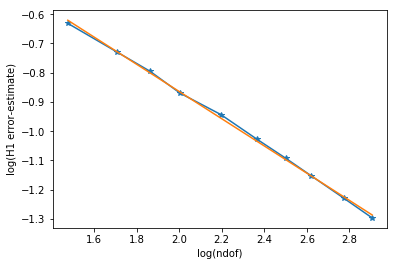

In [23]:
#Poisson problem with homogeneous Dirichlet boundary conditions using residual estimator and Dorfler marking

from ngsolve import *
import netgen.gui
from netgen.geom2d import SplineGeometry
from math import *
import numpy as np
%matplotlib inline



def MakeGeometry():
    geometry = SplineGeometry()
    
    # point coordinates ...
    pnts = [ (0,0), (1,0), (1,0.6), (0,0.6), \
             (0.2,0.6), (0.8,0.6), (0.8,0.8), (0.2,0.8), \
             (0.5,0.15), (0.65,0.3), (0.5,0.45), (0.35,0.3) ]
    pnums = [geometry.AppendPoint(*p) for p in pnts]
    
    # start-point, end-point, boundary-condition, domain on left side, domain on right side:
    lines = [ (0,1,1,1,0), (1,2,1,1,0), (2,5,1,1,0), (4,3,1,1,0), (3,0,1,1,0), \
              (5,6,1,1,0), (6,7,1,1,0), (7,4,1,1,0)]
        
    for p1,p2,bc,left,right in lines:
        geometry.Append( ["line", pnums[p1], pnums[p2]], bc=bc, leftdomain=left, rightdomain=right)
    return geometry



mesh = Mesh(MakeGeometry().GenerateMesh (maxh=0.2))
n = specialcf.normal(2)
h = specialcf.mesh_size


fes = H1(mesh, order=1, dirichlet=[1], autoupdate=True)
u = fes.TrialFunction()
v = fes.TestFunction()



a = BilinearForm(fes, symmetric=True)
a += grad(u)*grad(v)*dx

c = MultiGridPreconditioner(a, inverse = "sparsecholesky")
gfu = GridFunction(fes, autoupdate=True)
Draw (gfu)



f = LinearForm(fes)
fcoeff= CoefficientFunction(1)
f+=fcoeff*v*dx




def SolveBVP():
    a.Assemble()
    f.Assemble()
    inv = CGSolver(a.mat, c.mat)
    gfu.vec.data = inv * f.vec
    Redraw (blocking=True)


l = []

def hess(w): 
    return w.Operator("hesse")
def Lap(w):
   return hess(w)[0,0]+hess(w)[1,1]

def DorflerMarking(elerr):
        DorflerParam=0.25
        NpElError = np.array(elerr)
        SortedElError = np.sort(NpElError)[::-1]
        inds = np.argsort(NpElError)[::-1]
        Total = np.sum(NpElError)
        S=0
        counter=0
        while S<DorflerParam*Total:
            S=S+SortedElError[counter]
            counter=counter+1   
        for el in mesh.Elements():
            mesh.SetRefinementFlag(el, False) 
            for i in range(0,counter):
                el = mesh[ElementId(VOL,inds[i])]
                type(el)
                mesh.SetRefinementFlag(el,True)
 


def CalcError():
    err=(h*h)*((fcoeff+Lap(gfu))**2)*dx
    elerr = Integrate (err, mesh, element_wise=True)
    elerr += Integrate(h*0.5*((grad(gfu)-grad(gfu).Other())*n)**2*dx(element_boundary=True),mesh,element_wise=True)
    l.append ( (fes.ndof, sqrt(sum(elerr)) ))
    return elerr

    
    


with TaskManager():
    while fes.ndof < 1000:  
        SolveBVP()
        elerr=CalcError()
        DorflerMarking(elerr)
        mesh.Refine()
    
SolveBVP()

#print(count, 'count')

import matplotlib.pyplot as plt

plt.xlabel("log(ndof)")
plt.ylabel("log(H1 error-estimate)")
ndof,err = zip(*l)
plt.ion()
x=np.log10(np.array(ndof))
y=np.log10(np.array(err))
plt.plot(x,y, "-*")
m,b = np.polyfit(x, y, 1)
y1 = m*x+b

plt.plot(x,y1)

plt.savefig('Dorfler for DOF_1.png')
plt.show()


In [24]:
m

-0.46581409301922894

# Multiple plots for n=(1,2,3) for adaptive refinement

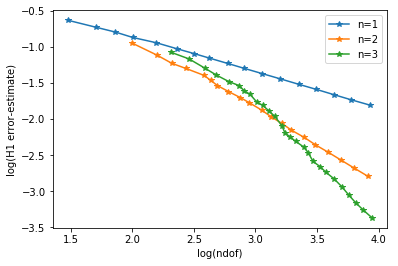

In [13]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

plt.xlabel("log(ndof)")
plt.ylabel("log(H1 error-estimate)")

x1=np.array([1.47712125, 1.70757018, 1.86332286, 2.00432137, 2.19589965,
       2.36361198, 2.50105926, 2.62117628, 2.77524626, 2.90687353,
       3.05614226, 3.20139712, 3.35468455, 3.49234125, 3.63688891,
       3.77524626, 3.92854947])
y1=np.array([-0.63115561, -0.72893337, -0.79498622, -0.86976433, -0.94304877,
       -1.02644737, -1.09267236, -1.15287073, -1.22994289, -1.2966575 ,
       -1.3712241 , -1.44289611, -1.52016766, -1.58810429, -1.66226192,
       -1.73229825, -1.80674334])
plt.plot(x1,y1, "-*")
x2=np.array([1.99563519, 2.20139712, 2.32221929, 2.4345689 , 2.58206336,
       2.63848926, 2.6919651 , 2.78103694, 2.87794695, 2.94743372,
       3.04999286, 3.12775252, 3.21298618, 3.29159083, 3.39532639,
       3.48727982, 3.59128727, 3.69679309, 3.80160949, 3.91550536])
y2=np.array([-0.94491871, -1.11480138, -1.22842391, -1.29834669, -1.39448599,
       -1.46582157, -1.53655159, -1.61896052, -1.70324193, -1.77112329,
       -1.87541909, -1.96961363, -2.057884  , -2.15388863, -2.25335557,
       -2.35769734, -2.46070671, -2.57088298, -2.67979487, -2.79589037])
plt.plot(x2,y2, "-*")
x3=np.array([2.31806333, 2.46089784, 2.58883173, 2.68214508, 2.78532984,
       2.87040391, 2.90741136, 2.95616843, 3.01283722, 3.05842602,
       3.11293998, 3.15594302, 3.21457895, 3.24004977, 3.27943879,
       3.32674538, 3.39111161, 3.42764837, 3.46805179, 3.52530401,
       3.57310378, 3.63858908, 3.70225816, 3.75617952, 3.8132473 ,
       3.87563994, 3.94743372])
y3=np.array([-1.07738612, -1.1665501 , -1.29423128, -1.38993695, -1.4821022 ,
       -1.53845443, -1.60771024, -1.65687716, -1.76852644, -1.80829589,
       -1.89296758, -1.96047703, -2.09232496, -2.19428163, -2.24467718,
       -2.3092149 , -2.38670203, -2.46450479, -2.58783314, -2.6602594 ,
       -2.73879072, -2.82931276, -2.93911578, -3.05025214, -3.15898745,
       -3.26181243, -3.37009997])
plt.plot(x3,y3, "-*")
plt.legend(["n=1", "n=2","n=3"])
m1,b1 = np.polyfit(x1, y1, 1)
yp1 = m1*x1+b1
#plt.plot(x1,yp1)
m2,b2 = np.polyfit(x2, y2, 1)
yp2 = m2*x2+b2
#plt.plot(x2,yp2)
m3,b3 = np.polyfit(x3, y3, 1)
yp3 = m3*x3+b3
#plt.plot(x3,yp3)
plt.savefig('adaptive with 1,2,3.png')
plt.show()

In [12]:
print('convergence rates are', m1,m2,m3 )

convergence rates are -0.48511269062294526 -0.9874715017484655 -1.5160965702946392


# Solving Poisson Problem with adaptive refinement


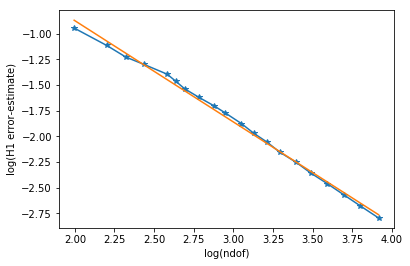

In [9]:
#Poisson problem with homogeneous Dirichlet boundary conditions using residual estimator and Dorfler marking

from ngsolve import *
import netgen.gui
from netgen.geom2d import SplineGeometry
from math import *
import numpy as np
%matplotlib inline


def MakeGeometry():
    geometry = SplineGeometry()
    
    # point coordinates ...
    pnts = [ (0,0), (1,0), (1,0.6), (0,0.6), \
             (0.2,0.6), (0.8,0.6), (0.8,0.8), (0.2,0.8), \
             (0.5,0.15), (0.65,0.3), (0.5,0.45), (0.35,0.3) ]
    pnums = [geometry.AppendPoint(*p) for p in pnts]
    
    # start-point, end-point, boundary-condition, domain on left side, domain on right side:
    lines = [ (0,1,1,1,0), (1,2,1,1,0), (2,5,1,1,0), (4,3,1,1,0), (3,0,1,1,0), \
              (5,6,1,1,0), (6,7,1,1,0), (7,4,1,1,0)]
        
    for p1,p2,bc,left,right in lines:
        geometry.Append( ["line", pnums[p1], pnums[p2]], bc=bc, leftdomain=left, rightdomain=right)
    return geometry



mesh = Mesh(MakeGeometry().GenerateMesh (maxh=0.2))
n = specialcf.normal(2)
h = specialcf.mesh_size


fes = H1(mesh, order=3, dirichlet=[1], autoupdate=True)
u = fes.TrialFunction()
v = fes.TestFunction()



a = BilinearForm(fes, symmetric=True)
a += grad(u)*grad(v)*dx

c = MultiGridPreconditioner(a, inverse = "sparsecholesky")
gfu = GridFunction(fes, autoupdate=True)
Draw (gfu)



f = LinearForm(fes)
fcoeff= CoefficientFunction(1)
f+=fcoeff*v*dx




def SolveBVP():
    a.Assemble()
    f.Assemble()
    inv = CGSolver(a.mat, c.mat)
    gfu.vec.data = inv * f.vec
    Redraw (blocking=True)


l = []

def hess(w): 
    return w.Operator("hesse")
def Lap(w):
   return hess(w)[0,0]+hess(w)[1,1]

def DorflerMarking(elerr):
        DorflerParam=0.25
        NpElError = np.array(elerr)
        SortedElError = np.sort(NpElError)[::-1]
        inds = np.argsort(NpElError)[::-1]
        Total = np.sum(NpElError)
        S=0
        counter=0
        while S<DorflerParam*Total:
            S=S+SortedElError[counter]
            counter=counter+1   
        for el in mesh.Elements():
            mesh.SetRefinementFlag(el, False) 
            for i in range(0,counter):
                el = mesh[ElementId(VOL,inds[i])]
                type(el)
                mesh.SetRefinementFlag(el,True)
 


def CalcError():
    err=(h*h)*((fcoeff+Lap(gfu))**2)*dx
    elerr = Integrate (err, mesh, element_wise=True)
    elerr += Integrate(h*0.5*((grad(gfu)-grad(gfu).Other())*n)**2*dx(element_boundary=True),mesh,element_wise=True)
    l.append ( (fes.ndof, sqrt(sum(elerr)) ))
    return elerr

    
    


with TaskManager():
    while fes.ndof < 10000:  
        SolveBVP()
        elerr=CalcError()
        DorflerMarking(elerr)
        mesh.Refine()
    
SolveBVP()

#print(count, 'count')

import matplotlib.pyplot as plt

plt.xlabel("log(ndof)")
plt.ylabel("log(H1 error-estimate)")
ndof,err = zip(*l)
plt.ion()
x=np.log10(np.array(ndof))
y=np.log10(np.array(err))
plt.plot(x,y, "-*")
m,b = np.polyfit(x, y, 1)
y1 = m*x+b

plt.plot(x,y1)

#plt.savefig('dorfler with uniform.png')
plt.show()

In [10]:
m

-0.987471506140469

# Checking Equidistribution for poisson problem  

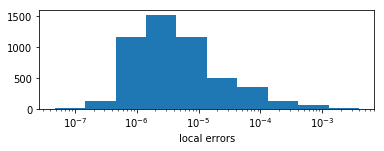

std deviation is 0.00016399277475674832


In [18]:
#checking equidistribution Poisson problem with homogeneous Dirichlet boundary conditions using residual estimator and Dorfler marking
from ngsolve import *
import netgen.gui
from netgen.geom2d import SplineGeometry
from math import *
import numpy as np
%matplotlib inline


def MakeGeometry():
    geometry = SplineGeometry()
    
    # point coordinates ...
    pnts = [ (0,0), (1,0), (1,0.6), (0,0.6), \
             (0.2,0.6), (0.8,0.6), (0.8,0.8), (0.2,0.8), \
             (0.5,0.15), (0.65,0.3), (0.5,0.45), (0.35,0.3) ]
    pnums = [geometry.AppendPoint(*p) for p in pnts]
    
    # start-point, end-point, boundary-condition, domain on left side, domain on right side:
    lines = [ (0,1,1,1,0), (1,2,1,1,0), (2,5,1,1,0), (4,3,1,1,0), (3,0,1,1,0), \
              (5,6,1,1,0), (6,7,1,1,0), (7,4,1,1,0)]
        
    for p1,p2,bc,left,right in lines:
        geometry.Append( ["line", pnums[p1], pnums[p2]], bc=bc, leftdomain=left, rightdomain=right)
    return geometry




mesh = Mesh(MakeGeometry().GenerateMesh (maxh=0.2))
n = specialcf.normal(2)
h = specialcf.mesh_size


fes = H1(mesh, order=1, dirichlet=[1], autoupdate=True)
u = fes.TrialFunction()
v = fes.TestFunction()


a = BilinearForm(fes, symmetric=True)
a += grad(u)*grad(v)*dx

c = MultiGridPreconditioner(a, inverse = "sparsecholesky")
gfu = GridFunction(fes, autoupdate=True)
Draw (gfu)


f = LinearForm(fes)
fcoeff= CoefficientFunction(1)
f+=fcoeff*v*dx




def SolveBVP():
    a.Assemble()
    f.Assemble()
    inv = CGSolver(a.mat, c.mat)
    gfu.vec.data = inv * f.vec
    Redraw (blocking=True)


l = []

def hess(w): 
    return w.Operator("hesse")
def Lap(w):
   return hess(w)[0,0]+hess(w)[1,1]

def DorflerMarking(elerr):
        DorflerParam=0.25
        NpElError = np.array(elerr)
        SortedElError = np.sort(NpElError)[::-1]
        inds = np.argsort(NpElError)[::-1]
        Total = np.sum(NpElError)
        S=0
        counter=0
        while S<DorflerParam*Total:
            S=S+SortedElError[counter]
            counter=counter+1   
        for el in mesh.Elements():
            mesh.SetRefinementFlag(el, False) 
            for i in range(0,counter):
                el = mesh[ElementId(VOL,inds[i])]
                type(el)
                mesh.SetRefinementFlag(el,True)
 

eqerr=[]

def CalcError(count,eqerr):

    err=(h*h)*((fcoeff+Lap(gfu))**2)*dx
    elerr = Integrate (err, mesh, element_wise=True)
    elerr += Integrate(h*0.5*((grad(gfu)-grad(gfu).Other())*n)**2*dx(element_boundary=True),mesh,element_wise=True)
    elerr = list(elerr)
    l.append ( (fes.ndof, sqrt(sum(elerr)) ))
    for i in elerr:
        eqerr.append(i)
    count=count+1
    return elerr, count, eqerr

    
    

count = 0
with TaskManager():
    while fes.ndof <1000:  
        SolveBVP()
        elerr,count,eqerr=CalcError(count,eqerr)
        DorflerMarking(elerr)
        mesh.Refine()
    
SolveBVP()



import matplotlib.pyplot as plt

mean=sum(eqerr)/len(eqerr)
y1=[mean]*len(eqerr)

eqerr = np.array(eqerr)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as scipy
from scipy import stats
from scipy.stats import norm

x=eqerr
hist, bins, _ = plt.hist(x, bins=10)
logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
plt.subplot(212)
plt.hist(x, bins=logbins)
plt.xscale('log')
plt.xlabel("local errors")
#plt.savefig('Error Equidistribution_3.png')
plt.show()
dev=np.std(eqerr)
print('std deviation is',dev)



# Problem 1


In [ ]:
#-nabla(u)+u=1 with neumann boundary condition (grad u.n=0) using residual estimator and Dorfler marking
from ngsolve import *
import netgen.gui
from math import *
import numpy as np
from netgen.geom2d import unit_square
%matplotlib inline


# generate a triangular mesh of mesh-size 0.2
mesh = Mesh(unit_square.GenerateMesh(maxh=0.2))

n = specialcf.normal(2)
h = specialcf.mesh_size


fes = H1(mesh, order=3, autoupdate=True, dgjumps=True)
u = fes.TrialFunction()
v = fes.TestFunction()
errspace = L2(mesh, order = 0, autoupdate=True,dgjumps=True) 
etaerr = errspace.TrialFunction()
q = errspace.TestFunction()

a = BilinearForm(fes, symmetric=True)
aerr = BilinearForm(errspace, symmetric=True)
a += grad(u)*grad(v)*dx+u*v*dx
aerr += etaerr*q*dx

c = MultiGridPreconditioner(a, inverse = "sparsecholesky")
gfu = GridFunction(fes, autoupdate=True)
Draw (gfu)
gfuerr = GridFunction(errspace,autoupdate=True)


f = LinearForm(fes)
fcoeff= CoefficientFunction(1)
gcoeff= CoefficientFunction(1)
f+=fcoeff*v*dx+gcoeff*v*ds
Ferr = LinearForm(errspace)
Ferr+=h*((gcoeff-grad(gfu)*n)**2)* 0.5*(q+q.Other())*ds('1')
Ferr+=h*((gcoeff-grad(gfu)*n)**2)* 0.5*(q+q.Other())*ds('2')
Ferr+=h*((gcoeff-grad(gfu)*n)**2)* 0.5*(q+q.Other())*ds('3')
Ferr+=h*((gcoeff-grad(gfu)*n)**2)* 0.5*(q+q.Other())*ds('4')



def SolveBVP():
    a.Assemble()
    f.Assemble()
    aerr.Assemble()
    Ferr.Assemble()
    inv = CGSolver(a.mat, c.mat)
    gfu.vec.data = inv * f.vec
    gfuerr.vec.data = aerr.mat.Inverse(errspace.FreeDofs())*Ferr.vec
    Redraw (blocking=True)


l = []

def hess(w): 
    return w.Operator("hesse")
def Lap(w):
   return hess(w)[0,0]+hess(w)[1,1]

def DorflerMarking(elerr):
        DorflerParam=0.25
        NpElError = np.array(elerr)
        SortedElError = np.sort(NpElError)[::-1]
        inds = np.argsort(NpElError)[::-1]
        Total = np.sum(NpElError)
        S=0
        counter=0
        while S<DorflerParam*Total:
            S=S+SortedElError[counter]
            counter=counter+1   
        for el in mesh.Elements():
            mesh.SetRefinementFlag(el, False) 
            for i in range(0,counter):
                el = mesh[ElementId(VOL,inds[i])]
                type(el)
                mesh.SetRefinementFlag(el,True)
 


def CalcError():

    err=(h*h)*((fcoeff+Lap(gfu)-gfu)**2)*dx
    elerr = Integrate (err, mesh, element_wise=True)
    elerr += Integrate(gfuerr,mesh, VOL, element_wise=True)
    elerr += Integrate(h*0.5*((grad(gfu)-grad(gfu).Other())*n)**2*dx(element_boundary=True),mesh,element_wise=True)
    
    l.append ( (fes.ndof, sqrt(sum(elerr)) ))
    return elerr

    
    


with TaskManager():
    while fes.ndof < 10000:  
        SolveBVP()
        elerr=CalcError()
        DorflerMarking(elerr)
        mesh.Refine()
    
SolveBVP()


import matplotlib.pyplot as plt

plt.xlabel("log(ndof)")
plt.ylabel("log(H1 error-estimate)")
ndof,elerr = zip(*l)
plt.ion()
x=np.log10(np.array(ndof))
y=np.log10(np.array(elerr))
plt.plot(x,y, "-*")
m,b = np.polyfit(x, y, 1)
y1 = m*x+b

plt.plot(x,y1)

plt.savefig('Problem_1.png')
plt.show()


# Problem 2

In [ ]:
#-nabla(u)+u_x-u_y=1 in on L-shaped domain, with homogeneous Dirichlet boundary conditions (u=0 on boundary) using residual estimator and Dorfler marking
from ngsolve import *
import netgen.gui
from netgen.geom2d import SplineGeometry
from math import *
import numpy as np
%matplotlib inline


def MakeGeometry():
    geometry = SplineGeometry()
    
    # point coordinates ...
    pnts = [ (0,0), (1,0), (1,0.6), (0.5,0.6), (0.5, 0.8), (0, 0.8) ]
    pnums = [geometry.AppendPoint(*p) for p in pnts]
    
    # start-point, end-point, boundary-condition, domain on left side, domain on right side:
    lines = [ (0,1,1,1,0), (1,2,1,1,0), (2,3,1,1,0), (3,4,1,1,0), (4,5,1,1,0), (5,0,1,1,0)]
        
    for p1,p2,bc,left,right in lines:
        geometry.Append( ["line", pnums[p1], pnums[p2]], bc=bc, leftdomain=left, rightdomain=right)
    return geometry




mesh = Mesh(MakeGeometry().GenerateMesh (maxh=0.2))


n = specialcf.normal(2)
h = specialcf.mesh_size


fes = H1(mesh, order=3, dirichlet=[1], autoupdate=True)
u = fes.TrialFunction()
v = fes.TestFunction()


a = BilinearForm(fes, symmetric=True)
a += grad(u)*grad(v)*dx+grad(u)[0]*v*dx-grad(u)[1]*v*dx

c = MultiGridPreconditioner(a, inverse = "sparsecholesky")
gfu = GridFunction(fes, autoupdate=True)
Draw (gfu)


f = LinearForm(fes)
fcoeff= CoefficientFunction(1)
f+=fcoeff*v*dx




def SolveBVP():
    a.Assemble()
    f.Assemble()
    inv = CGSolver(a.mat, c.mat)
    gfu.vec.data = inv * f.vec
    Redraw (blocking=True)


l = []

def hess(w): 
    return w.Operator("hesse")
def Lap(w):
   return hess(w)[0,0]+hess(w)[1,1]

def DorflerMarking(elerr):
        DorflerParam=0.25
        NpElError = np.array(elerr)
        SortedElError = np.sort(NpElError)[::-1]
        inds = np.argsort(NpElError)[::-1]
        Total = np.sum(NpElError)
        S=0
        counter=0
        while S<DorflerParam*Total:
            S=S+SortedElError[counter]
            counter=counter+1   
        for el in mesh.Elements():
            mesh.SetRefinementFlag(el, False) 
            for i in range(0,counter):
                el = mesh[ElementId(VOL,inds[i])]
                type(el)
                mesh.SetRefinementFlag(el,True)
 


def CalcError():

    err=(h*h)*((fcoeff+Lap(gfu)-grad(gfu)[0]+grad(gfu)[1])**2)*dx
    elerr = Integrate (err, mesh, element_wise=True)
    elerr += Integrate(h*0.5*((grad(gfu)-grad(gfu).Other())*n)**2*dx(element_boundary=True),mesh,element_wise=True)
    l.append ( (fes.ndof, sqrt(sum(elerr)) ))
    return elerr

    
    


with TaskManager():
    while fes.ndof < 10000:  
        SolveBVP()
        elerr=CalcError()
        DorflerMarking(elerr)
        mesh.Refine()
    
SolveBVP()



import matplotlib.pyplot as plt

plt.xlabel("log(ndof)")
plt.ylabel("log(H1 error-estimate)")
ndof,elerr = zip(*l)
plt.ion()
x=np.log10(np.array(ndof))
y=np.log10(np.array(elerr))
plt.plot(x,y, "-*")
m,b = np.polyfit(x, y, 1)
y1 = m*x+b

plt.plot(x,y1)

plt.savefig('problem_2.png')
plt.show()


# Problem 3

In [ ]:
#-(nabla(u))+b.grad(u)+u=1 in L-Shaped domain,b=(x,y) ,u=0 in T_D using residual estimator and  dorfler marking
from ngsolve import *
import netgen.gui
from netgen.geom2d import SplineGeometry
from math import *
import numpy as np
%matplotlib inline



def MakeGeometry():
    geometry = SplineGeometry()
    
    # point coordinates ...
    pnts = [ (0,0), (1,0), (1,0.6), (0.5,0.6), (0.5, 0.8), (0, 0.8) ]
    pnums = [geometry.AppendPoint(*p) for p in pnts]
    
    # start-point, end-point, boundary-condition, domain on left side, domain on right side:
    lines = [ (0,1,1,1,0), (1,2,1,1,0), (2,3,1,1,0), (3,4,1,1,0), (4,5,1,1,0), (5,0,1,1,0)]
        
    for p1,p2,bc,left,right in lines:
        geometry.Append( ["line", pnums[p1], pnums[p2]], bc=bc, leftdomain=left, rightdomain=right)
    return geometry



mesh = Mesh(MakeGeometry().GenerateMesh (maxh=0.2))
n = specialcf.normal(2)
h = specialcf.mesh_size


fes = H1(mesh, order=3, dirichlet=[1], autoupdate=True)
u = fes.TrialFunction()
v = fes.TestFunction()
b_t = CoefficientFunction((x,y))


a = BilinearForm(fes, symmetric=True)
a += grad(u)*grad(v)*dx+np.dot(b_t, grad(u))*v*dx+u*v*dx

c = MultiGridPreconditioner(a, inverse = "sparsecholesky")
gfu = GridFunction(fes, autoupdate=True)
Draw (gfu)


f = LinearForm(fes)
fcoeff= CoefficientFunction(1)
f+=fcoeff*v*dx



def SolveBVP():
    a.Assemble()
    f.Assemble()
    inv = CGSolver(a.mat, c.mat)
    gfu.vec.data = inv * f.vec
    Redraw (blocking=True)


l = []

def hess(w): 
    return w.Operator("hesse")
def Lap(w):
   return hess(w)[0,0]+hess(w)[1,1]

def DorflerMarking(elerr):
        DorflerParam=0.25
        NpElError = np.array(elerr)
        SortedElError = np.sort(NpElError)[::-1]
        inds = np.argsort(NpElError)[::-1]
        Total = np.sum(NpElError)
        S=0
        counter=0
        while S<DorflerParam*Total:
            S=S+SortedElError[counter]
            counter=counter+1   
        for el in mesh.Elements():
            mesh.SetRefinementFlag(el, False) 
            for i in range(0,counter):
                el = mesh[ElementId(VOL,inds[i])]
                type(el)
                mesh.SetRefinementFlag(el,True)
 


def CalcError():
    dif=np.dot(b_t,grad(gfu))
    err=(h*h)*((fcoeff+Lap(gfu)-dif-gfu)**2)*dx
    elerr = Integrate (err, mesh, element_wise=True)
    elerr += Integrate(h*0.5*((grad(gfu)-grad(gfu).Other())*n)**2*dx(element_boundary=True),mesh,element_wise=True)
    l.append ( (fes.ndof, sqrt(sum(elerr)) ))
    return elerr

    
    


with TaskManager():
    while fes.ndof < 10000:  
        SolveBVP()
        elerr=CalcError()
        DorflerMarking(elerr)
        mesh.Refine()
    
SolveBVP()



import matplotlib.pyplot as plt

plt.xlabel("log(ndof)")
plt.ylabel("log(H1 error-estimate)")
ndof,elerr = zip(*l)
plt.ion()
x=np.log10(np.array(ndof))
y=np.log10(np.array(elerr))
plt.plot(x,y, "-*")
m,b = np.polyfit(x, y, 1)
y1 = m*x+b

plt.plot(x,y1)

#plt.savefig('Problem_3.png')
plt.show()

# Problem 4


In [ ]:
#-(nabla(u))+b.grad(u)=1 in omega,b=(-6y,6x) ,u=0 in T_D and grad(u).n=0 in T_N  using residual estimator and 
# dorfler marking
from ngsolve import *
import netgen.gui
from netgen.geom2d import SplineGeometry
from math import *
import numpy as np
%matplotlib inline

geo = SplineGeometry()
geo.AddCircle ( (0, 0), r=1, bc="circle")

mesh = Mesh(geo.GenerateMesh(maxh=0.2))
n = specialcf.normal(2)
h = specialcf.mesh_size


fes = H1(mesh, order=3, dirichlet="circle", autoupdate=True)
u = fes.TrialFunction()
v = fes.TestFunction()
b_t = CoefficientFunction((-6*y,6*x))

a = BilinearForm(fes, symmetric=True)
a += grad(u)*grad(v)*dx+np.dot(b_t, grad(u))*v*dx

c = MultiGridPreconditioner(a, inverse = "sparsecholesky")
gfu = GridFunction(fes, autoupdate=True)
Draw (gfu)


f = LinearForm(fes)
fcoeff= CoefficientFunction(1)
f+=fcoeff*v*dx




def SolveBVP():
    a.Assemble()
    f.Assemble()
    inv = CGSolver(a.mat, c.mat)
    gfu.vec.data = inv * f.vec
    Redraw (blocking=True)


l = []

def hess(w): 
    return w.Operator("hesse")
def Lap(w):
   return hess(w)[0,0]+hess(w)[1,1]

def DorflerMarking(elerr):
        DorflerParam=0.25
        NpElError = np.array(elerr)
        SortedElError = np.sort(NpElError)[::-1]
        inds = np.argsort(NpElError)[::-1]
        Total = np.sum(NpElError)
        S=0
        counter=0
        while S<DorflerParam*Total:
            S=S+SortedElError[counter]
            counter=counter+1   
        for el in mesh.Elements():
            mesh.SetRefinementFlag(el, False) 
            for i in range(0,counter):
                el = mesh[ElementId(VOL,inds[i])]
                type(el)
                mesh.SetRefinementFlag(el,True)
 


def CalcError():
    dif=np.dot(b_t,grad(gfu))
    err=(h*h)*((fcoeff+Lap(gfu)-dif)**2)*dx
    elerr = Integrate (err, mesh, element_wise=True)
    elerr += Integrate(h*0.5*((grad(gfu)-grad(gfu).Other())*n)**2*dx(element_boundary=True),mesh,element_wise=True)
    l.append ( (fes.ndof, sqrt(sum(elerr)) ))
    return elerr

    
    


with TaskManager():
    while fes.ndof < 10000:  
        SolveBVP()
        elerr=CalcError()
        DorflerMarking(elerr)
        mesh.Refine()
    
SolveBVP()



import matplotlib.pyplot as plt

plt.xlabel("log(ndof)")
plt.ylabel("log(H1 error-estimate)")
ndof,elerr = zip(*l)
plt.ion()
x=np.log10(np.array(ndof))
y=np.log10(np.array(elerr))
plt.plot(x,y, "-*")
m,b = np.polyfit(x, y, 1)
y1 = m*x+b

plt.plot(x,y1)

#plt.savefig('problem_4.png')
plt.show()


# Convergence with Z-Z Type estimator for model problem

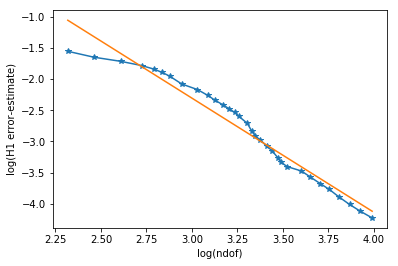

In [19]:
#Implementation of z-z type error estimator alongwith dorfler marking
from ngsolve import *
import netgen.gui
from netgen.geom2d import SplineGeometry
from math import *
import numpy as np
%matplotlib inline


def MakeGeometry():
    geometry = SplineGeometry()
    
    # point coordinates ...
    pnts = [ (0,0), (1,0), (1,0.6), (0,0.6), \
             (0.2,0.6), (0.8,0.6), (0.8,0.8), (0.2,0.8), \
             (0.5,0.15), (0.65,0.3), (0.5,0.45), (0.35,0.3) ]
    pnums = [geometry.AppendPoint(*p) for p in pnts]
    
    # start-point, end-point, boundary-condition, domain on left side, domain on right side:
    lines = [ (0,1,1,1,0), (1,2,1,1,0), (2,5,1,1,0), (4,3,1,1,0), (3,0,1,1,0), \
              (5,6,1,1,0), (6,7,1,1,0), (7,4,1,1,0)]
        
    for p1,p2,bc,left,right in lines:
        geometry.Append( ["line", pnums[p1], pnums[p2]], bc=bc, leftdomain=left, rightdomain=right)
    return geometry



mesh = Mesh(MakeGeometry().GenerateMesh (maxh=0.2))


fes = H1(mesh, order=3, dirichlet=[1], autoupdate=True)
u = fes.TrialFunction()
v = fes.TestFunction()

lam = CoefficientFunction(1)
a = BilinearForm(fes, symmetric=False)
a += lam*grad(u)*grad(v)*dx


f = LinearForm(fes)
f += CoefficientFunction(1)*v*dx

c = MultiGridPreconditioner(a, inverse = "sparsecholesky")

gfu = GridFunction(fes, autoupdate=True)
Draw (gfu)

space_flux = HDiv(mesh, order=3, autoupdate=True)
gf_flux = GridFunction(space_flux, "flux", autoupdate=True)

def SolveBVP():
    a.Assemble()
    f.Assemble()
    inv = CGSolver(a.mat, c.mat)
    gfu.vec.data = inv * f.vec
    Redraw (blocking=True)



l = []
def DorflerMarking(elerr):
        DorflerParam=0.25
        NpElError = np.array(elerr)
        SortedElError = np.sort(NpElError)[::-1]
        inds = np.argsort(NpElError)[::-1]
        Total = np.sum(NpElError)
        S=0
        counter=0
        while S<DorflerParam*Total:
            S=S+SortedElError[counter]
            counter=counter+1   
        for el in mesh.Elements():
            mesh.SetRefinementFlag(el, False) 
            for i in range(0,counter):
                el = mesh[ElementId(VOL,inds[i])]
                type(el)
                mesh.SetRefinementFlag(el,True)

def CalcError():
    flux = lam * grad(gfu)
    gf_flux.Set (flux)
    # Gradient-recovery error estimator
    err = 1/lam*(flux-gf_flux)*(flux-gf_flux)
    elerr = Integrate (err, mesh, VOL, element_wise=True)
    l.append ( (fes.ndof, sqrt(sum(elerr)) ))
    return elerr

with TaskManager():
    while fes.ndof < 10000:  
        SolveBVP()
        elerr= CalcError()
        DorflerMarking(elerr)
        mesh.Refine()
    
SolveBVP()

import matplotlib.pyplot as plt

plt.xlabel("log(ndof)")
plt.ylabel("log(H1 error-estimate)")
ndof,elerr = zip(*l)
plt.ion()
x=np.log10(np.array(ndof))
y=np.log10(np.array(elerr))
plt.plot(x,y, "-*")
m,b = np.polyfit(x, y, 1)
y1 = m*x+b

plt.plot(x,y1)

plt.savefig('z-z_error_estimator.png')
plt.show()



In [20]:
m

-1.8306801815000535

# Checking Efficiency of our residual type error estimator

estimated Error is 0.0026965893943760094
H1 Error is 0.0002049488174342258
estimated Error is 0.0020057153929267093
H1 Error is 0.00015453712238021032
estimated Error is 0.0014846879312363876
H1 Error is 0.00011206797028336098
estimated Error is 0.0010295677401160018
H1 Error is 8.481462170153585e-05
estimated Error is 0.0007321164942548748
H1 Error is 5.795930358464959e-05
estimated Error is 0.000555853268479845
H1 Error is 4.347189616194532e-05
estimated Error is 0.0004245656269863853
H1 Error is 3.320372531547491e-05
estimated Error is 0.00031883379351681484
H1 Error is 2.5893908670046e-05
estimated Error is 0.00024615354415216873
H1 Error is 2.1308490377437922e-05
estimated Error is 0.00018258318745898128
H1 Error is 1.545892591759317e-05
estimated Error is 0.00013914679975422298
H1 Error is 1.1135297347476684e-05
estimated Error is 0.00011324599880430218
H1 Error is 9.034411385024602e-06
estimated Error is 8.858075135365813e-05
H1 Error is 6.949696600833153e-06
estimated Error is 

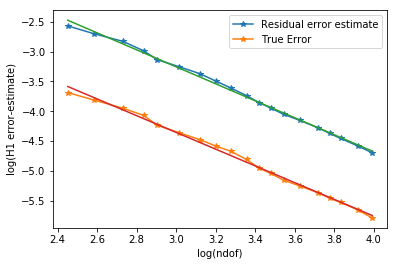

In [1]:
#solving poisson equation on a square domain with homogeneous BC
from ngsolve import *
import netgen.gui
from math import *
import numpy as np
from netgen.geom2d import unit_square
%matplotlib inline


# generate a triangular mesh of mesh-size 0.2
mesh = Mesh(unit_square.GenerateMesh(maxh=0.2))

n = specialcf.normal(2)
h = specialcf.mesh_size


fes = H1(mesh, order=3, dirichlet=[1,2,3,4], autoupdate=True)
u = fes.TrialFunction()
v = fes.TestFunction()

a = BilinearForm(fes, symmetric=True)
a += grad(u)*grad(v)*dx

c = MultiGridPreconditioner(a, inverse = "sparsecholesky")
gfu = GridFunction(fes, autoupdate=True)
Draw (gfu)
u_exact=x*(1-x)*y*(1-y)
du0=y*(1-y)*(1-2*x)
du1=x*(1-x)*(1-2*y)

f = LinearForm(fes)
fcoeff= 2 * (y*(1-y)+x*(1-x))
f+=fcoeff*v*dx




def SolveBVP():
    a.Assemble()
    f.Assemble()
    inv = CGSolver(a.mat, c.mat)
    gfu.vec.data = inv * f.vec
    Redraw (blocking=True)




def hess(w): 
    return w.Operator("hesse")
def Lap(w):
   return hess(w)[0,0]+hess(w)[1,1]

def DorflerMarking(elerr):
        DorflerParam=0.25
        NpElError = np.array(elerr)
        SortedElError = np.sort(NpElError)[::-1]
        inds = np.argsort(NpElError)[::-1]
        Total = np.sum(NpElError)
        S=0
        counter=0
        while S<DorflerParam*Total:
            S=S+SortedElError[counter]
            counter=counter+1   
        for el in mesh.Elements():
            mesh.SetRefinementFlag(el, False) 
            for i in range(0,counter):
                el = mesh[ElementId(VOL,inds[i])]
                type(el)
                mesh.SetRefinementFlag(el,True)
 
l = []
L = []
def d0(u): 
    return grad(u)[0]
def d1(u): 
    return grad(u)[1]


def CalcError():
    err=(h*h)*((fcoeff+Lap(gfu))**2)*dx
    elerr = Integrate (err, mesh, element_wise=True)
    elerr += Integrate(h*0.5*((grad(gfu)-grad(gfu).Other())*n)**2*dx(element_boundary=True), mesh, element_wise=True)
    print('estimated Error is', sqrt(sum(elerr)))
    l.append ( (fes.ndof, sqrt(sum(elerr)) ))
    return elerr
   
def H1Error():
    #H1Err = Integrate((gfu-u_exact)*(gfu-u_exact), mesh, order=6)
    H1Err = Integrate((du0-d0(gfu))**2+(du1-d1(gfu))**2, mesh, order=6)
    print('H1 Error is', sqrt(H1Err))
    L.append ( (fes.ndof, sqrt(H1Err )))
    return H1Err

    


with TaskManager():
    while fes.ndof < 10000:  
        SolveBVP()
        elerr=CalcError()
        H1Err=H1Error()
        DorflerMarking(elerr)
        mesh.Refine()
    
SolveBVP()



import matplotlib.pyplot as plt


plt.xlabel("log(ndof)")
plt.ylabel("log(H1 error-estimate)")
ndof,elerr = zip(*l)
ndof,H1Err = zip(*L)
plt.ion()
x=np.log10(np.array(ndof))
y=np.log10(np.array(elerr))
y_1=np.log10(np.array(H1Err))
plt.plot(x,y, "-*")
plt.plot(x,y_1, "-*")
plt.legend(["Residual error estimate", "True Error"])
m,b = np.polyfit(x, y, 1)
m1,b1 = np.polyfit(x , y_1, 1)
y1 = m*x+b
y2 = m1*x+b1
plt.plot(x, y1)
plt.plot(x, y2)
xmax=max(x)
y1min=min(y)
y2min=min(y1)
plt.vlines(x=xmax, ymin=y2min, ymax=y1min)
#plt.savefig('Efficiency')
plt.show()


# Finding Efficiency Index

In [7]:
ylist=np.asarray(elerr)
ylist


array([2.69658939e-03, 2.00571539e-03, 1.48468793e-03, 1.02956774e-03,
       7.32116494e-04, 5.55853268e-04, 4.24565627e-04, 3.18833794e-04,
       2.46153544e-04, 1.82583187e-04, 1.39146800e-04, 1.13245999e-04,
       8.85807514e-05, 6.98198295e-05, 5.27486784e-05, 4.23005037e-05,
       3.48549473e-05, 2.60041761e-05, 2.00705834e-05])

In [8]:
y1list=np.asarray(H1Err)
y1list

array([2.04975187e-04, 1.54554890e-04, 1.12078797e-04, 8.48220040e-05,
       5.79629244e-05, 4.34741850e-05, 3.32052669e-05, 2.58949242e-05,
       2.13092783e-05, 1.54593805e-05, 1.11355531e-05, 9.03460034e-06,
       6.94981259e-06, 5.53718280e-06, 4.27412156e-06, 3.46028250e-06,
       2.93713488e-06, 2.19725415e-06, 1.61682472e-06])

In [15]:
y2list=ylist/y1list
y2list

array([13.15568695, 12.97736615, 13.24682253, 12.13797943, 12.63077221,
       12.78582378, 12.78609288, 12.31259804, 11.55147257, 11.81051127,
       12.49572414, 12.53469933, 12.74577555, 12.60926937, 12.34140807,
       12.224581  , 11.86698899, 11.83485127, 12.4135803 ])

In [13]:
N=np.array(ndof)
N

array([ 283,  382,  538,  685,  802, 1036, 1321, 1591, 1885, 2269, 2623,
       3004, 3496, 4234, 5215, 5980, 6793, 8305, 9802])

In [18]:
y2l=y2list[::4]
Nl=N[::4]


array([13.15568695, 12.63077221, 11.55147257, 12.74577555, 11.86698899])

In [19]:
Nl

array([ 283,  802, 1885, 3496, 6793])